In [2]:
import setGPU

from keras.datasets import mnist
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.models import model_from_json

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import os
from random import shuffle, randint, choice

setGPU: Setting GPU to: 0


In [3]:
# Generates random image with squares and circles
def getRandomImage():
    imageSize = 100
    size = 25
    nbShapes = 5

    xy = lambda: randint(0,100)

    # Create a white image
    img = np.zeros((imageSize,imageSize,3), np.uint8)
    cv2.rectangle(img,(0,0),(imageSize,imageSize),(122,122,122) ,-1)

    greyImg = np.copy(img)

    # Adds some shapes
    for i in range(nbShapes):
        x0, y0 = xy(), xy()
        isRect = choice((True,False))
        if isRect:
            cv2.rectangle(img,(x0,y0),(x0+size,y0+size),(255,0,0) ,-1)
            cv2.rectangle(greyImg,(x0,y0),(x0+size,y0+size),(255,255,255) ,-1)
        else:
            cv2.circle(img,(x0,y0), int(size/2), (0,0,255), -1)
            cv2.circle(greyImg,(x0,y0), int(size/2), (255,255,255), -1)

    return cv2.resize(img,(48,48)), cv2.resize(greyImg,(48,48))

In [4]:
# Creates the dataset
def getDataset(display=False):
    # Show what the dataset looks like
    if display:
        colorImg, greyImg = getRandomImage()
        img = np.hstack((colorImg, greyImg))
        res_img = cv2.resize(img, (200, 100))
        plt.imshow(res_img)
        plt.axis("off")
        plt.show()
        cv2.destroyAllWindows()

    #for i in range

    x_train, x_test, y_train, y_test = [], [], [], []

    # Add training examples
    for i in range(10000):
        colorImg, greyImg = getRandomImage()
        greyImg = cv2.cvtColor(greyImg, cv2.COLOR_RGB2GRAY)
        x_train.append(greyImg.astype('float32')/255.)
        y_train.append(colorImg.astype('float32')/255.)

    # Add test examples
    for i in range(1000):
        colorImg, greyImg = getRandomImage()
        greyImg = cv2.cvtColor(greyImg, cv2.COLOR_RGB2GRAY)
        x_test.append(greyImg.astype('float32')/255.)
        y_test.append(colorImg.astype('float32')/255.)

    # Reshape
    x_train = np.array(x_train).reshape((-1,48,48,1))
    x_test = np.array(x_test).reshape((-1,48,48,1))
    y_train = np.array(y_train).reshape((-1,48,48,3))
    y_test = np.array(y_test).reshape((-1,48,48,3))

    return x_train, y_train, x_test, y_test

In [9]:
# Creates the Convolutional Auto Encoder
def getModel():
    input_img = tf.keras.layers.Input(shape=(48, 48, 1))
    x = tf.keras.layers.Convolution2D(16, 3, 3, activation='relu', border_mode='same', dim_ordering='tf')(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), border_mode='same', dim_ordering='tf')(x)
    x = tf.keras.layers.Convolution2D(32, 3, 3, activation='relu', border_mode='same', dim_ordering='tf')(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), border_mode='same', dim_ordering='tf')(x)
    x = tf.keras.layers.Convolution2D(64, 3, 3, activation='relu', border_mode='same', dim_ordering='tf')(x)
    encoded = tf.keras.layers.MaxPooling2D((2, 2), border_mode='same', dim_ordering='tf')(x)
    
    #6x6x32 -- bottleneck
    x = tf.keras.layers.UpSampling2D((2, 2), dim_ordering='tf')(encoded)
    x = tf.keras.layers.Convolution2D(32, 3, 3, activation='relu', border_mode='same', dim_ordering='tf')(x)
    x = tf.keras.layers.UpSampling2D((2, 2), dim_ordering='tf')(x)
    x = tf.keras.layers.Convolution2D(16, 3, 3, activation='relu', border_mode='same', dim_ordering='tf')(x)
    decoded = tf.keras.layers.Convolution2D(3, 3, 3, activation='relu', border_mode='same', dim_ordering='tf')(x)

    #Create model
    autoencoder = tf.keras.models.Model(input_img, decoded)
    return autoencoder

In [6]:
# Trains the model for 10 epochs
def trainModel():
    # Load dataset
    print("Loading dataset...")
    x_train_gray, x_train, x_test_gray, x_test = getDataset()

    # Create model description
    print("Creating model...")
    model = getModel()
    model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])

    # Train model
    print("Training model...")
    model.fit(x_train_gray, x_train, nb_epoch=10, batch_size=148, shuffle=True, validation_data=(x_test_gray, x_test), 
              callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

    # Evaluate loaded model on test data
    print("Evaluating model...")
    score = model.evaluate(x_train_gray, x_train, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

    # Serialize model to JSON
    print("Saving model...")
    model_json = model.to_json()
    with open("../../outputsmodel.json", "w") as json_file:
        json_file.write(model_json)

    # Serialize weights to HDF5
    print("Saving weights...")
    model.save_weights("../../outputs/model/model.h5")

In [7]:
# Tests the model and shows results
def testModel():
    # Load JSON model description
    with open('model.json', 'r') as json_file:
        modelJSON = json_file.read()

    # Build model from JSON description
    print("Loading model...")
    model = model_from_json(modelJSON)

    # Load weights
    print("Loading weights...")
    model.load_weights("model.h5")

    _, _, x_test_gray, x_test = getDataset()
    x_test_gray = x_test_gray[:10]
    x_test = x_test[:10]

    print("Making predictions...")
    predictions = model.predict(x_test_gray)
    x_test_gray = [cv2.cvtColor(img,cv2.COLOR_GRAY2RGB) for img in x_test_gray]

    img = np.vstack((np.hstack(x_test_gray),np.hstack(predictions),np.hstack(x_test)))

    res_img = cv2.resize(img, (img.shape[1], img.shape[0]))
    plt.imshow(res_img)
    plt.axis('off')
    plt.show()

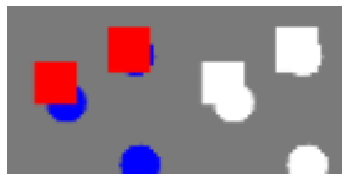

Loading dataset...
Creating model...



/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", padding="same", data_format="channels_last")`
  after removing the cwd from sys.path.
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="same", data_format="channels_last")`
  """
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same", data_format="channels_last")`
  
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="same", data_format="channels_last")`
  import sys
/home/vuu/anaconda3/envs/tfpy3_e

Training model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app



Train on 10000 samples, validate on 1000 samples


Epoch 1/10
10000/10000 [==============================] - 4s 374us/step - loss: 0.8223 - accuracy: 0.1068 - val_loss: 0.6841 - val_accuracy: 0.1311

Epoch 2/10
10000/10000 [==============================] - 1s 116us/step - loss: 0.6807 - accuracy: 0.1275 - val_loss: 0.6618 - val_accuracy: 0.1360
Epoch 3/10
10000/10000 [==============================] - 1s 103us/step - loss: 0.6529 - accuracy: 0.1461 - val_loss: 0.6528 - val_accuracy: 0.1402
Epoch 4/10
10000/10000 [==============================] - 1s 98us/step - loss: 0.6288 - accuracy: 0.1627 - val_loss: 0.6086 - val_accuracy: 0.1763
Epoch 5/10
10000/10000 [==============================] - 1s 104us/step - loss: 0.6188 - accuracy: 0.1710 - val_loss: 0.5958 - val_accuracy: 0.1788
Epoch 6/10
10000/10000 [==============================] - 1s 103us/step - loss: 0.6062 - accuracy: 0.1735 - val_loss: 0.5889 - val_accuracy: 0.1804
Epoch 7/10
10000/10000 [==============================] - 1s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Making predictions...


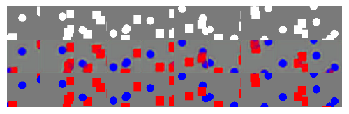

In [8]:
if __name__ == "__main__":
    getDataset(True)
    trainModel()
    testModel()